In [1]:
!pip install pycombo

     |████████████████████████████████| 136 kB 3.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 213 kB 38.9 MB/s 
  Using cached importlib_metadata-1.7.0-py2.py3-none-any.whl (31 kB)
  Created wheel for pycombo: filename=pycombo-0.1.7-cp37-cp37m-manylinux_2_27_x86_64.whl size=98830 sha256=9e19beca46226f3c9742a00b868b377976ed462204d0dc244d4b1c47ed62f386
  Stored in directory: /root/.cache/pip/wheels/58/52/18/4c1b80cd45c091e2c1ea442729343ac984dc66b3a678e2c251
Successfully built pycombo
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.3
    Uninstalling importlib-metadata-4.11.3:
      Successfully uninstalled importlib-metadata-4.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdo

In [2]:
#add necessary libraries
import pycombo # combo community detection package
import networkx as nx #library supporting networks
from networkx.algorithms import community
import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np
import scipy.stats as stat
#make sure plots are embedded into the notebook
%pylab inline 
import statsmodels.formula.api as smf

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
gdf = pd.read_csv('event_related_tripdata.csv')
gdf.head()

,Unnamed: 0,started_at,ended_at,start_station_name,start_lat,start_lng,end_station_name,end_lat,end_lng,event_id,...,zipcode,population_over16_with_earnings,median_earnings,total_population,median_age,white,black,american_indian,asian,geometry
0,0,2021-01-01 00:30:06.623000,2021-01-01 00:42:50.044000,Grand Army Plaza & Central Park S,40.764397,-73.973715,W 45 St & 8 Ave,40.759291,-73.988597,547196.0,...,10019.0,32071.0,83576.0,45498.0,38.3,30408.0,2738.0,362.0,8695.0,POINT (-73.9736233 40.7640234)
1,1,2021-01-01 00:43:27.924000,2021-01-01 00:56:46.599000,E 58 St & Madison Ave,40.763026,-73.972095,W 47 St & 10 Ave,40.762699,-73.993012,547196.0,...,10019.0,32071.0,83576.0,45498.0,38.3,30408.0,2738.0,362.0,8695.0,POINT (-73.9736233 40.7640234)
2,2,2021-01-01 01:01:46.645000,2021-01-01 01:24:12.334000,Grand Army Plaza & Central Park S,40.764397,-73.973715,4 Ave & E 12 St,40.732647,-73.990110,547196.0,...,10019.0,32071.0,83576.0,45498.0,38.3,30408.0,2738.0,362.0,8695.0,POINT (-73.9736233 40.7640234)
3,3,2021-01-01 05:53:30.416000,2021-01-01 05:59:05.592000,5 Ave & E 135 St,40.812191,-73.937838,St Nicholas Ave & E 134 St,40.816234,-73.948222,518747.0,...,10037.0,9263.0,42218.0,20462.0,36.1,2083.0,14573.0,68.0,571.0,POINT (-73.9372146 40.81229709999999)
4,4,2021-01-01 08:58:30.463000,2021-01-01 09:29:33.094000,Wards Meadow Comfort Station,40.782940,-73.930770,E 58 St & 1 Ave (NW Corner),40.759125,-73.962658,547285.0,...,10035.0,15423.0,34120.0,36048.0,36.1,7552.0,14481.0,196.0,1504.0,POINT (-73.9291969 40.7838292)


In [4]:
gdf = gdf.dropna()
for c in gdf['end_station_name']:
    if c == 'E 58 St &  1 Ave (NW Corner)':
        c = 'E 58 St & 1 Ave (NW Corner)'

In [5]:
end_stations_locations = gdf[['end_station_name', 'end_lat', 'end_lng']].drop_duplicates(['end_station_name'])
end_stations_locations = end_stations_locations.rename(columns={"end_station_name": "station_name", "end_lat": "lat", "end_lng": "lng"})
end_stations_locations.index = end_stations_locations['station_name']
#end_stations_locations = end_stations_locations.drop(columns=['station_name'])

start_stations_locations = gdf[['start_station_name', 'start_lat', 'start_lng']].drop_duplicates(['start_station_name'])
start_stations_locations = start_stations_locations.rename(columns={"start_station_name": "station_name", "start_lat": "lat", "start_lng": "lng"})
start_stations_locations.index = start_stations_locations['station_name']
#start_stations_locations = start_stations_locations.drop(columns=['station_name'])

stations_locations = pd.concat([start_stations_locations, end_stations_locations]).drop_duplicates(['station_name'])
#stations_locations.index = stations_locations['station_name']
#stations_locations = stations_locations.drop(columns=['station_name']).drop_duplicates()
len(stations_locations)

1264

In [6]:
start_stations_locations['lat']['Mott St & Prince St']

40.72317958

In [7]:
stations=nx.Graph()
stations.add_nodes_from(stations_locations.index)

In [8]:
stationPos={c:(stations_locations['lng'][c],stations_locations['lat'][c])
         for c in stations_locations.index}


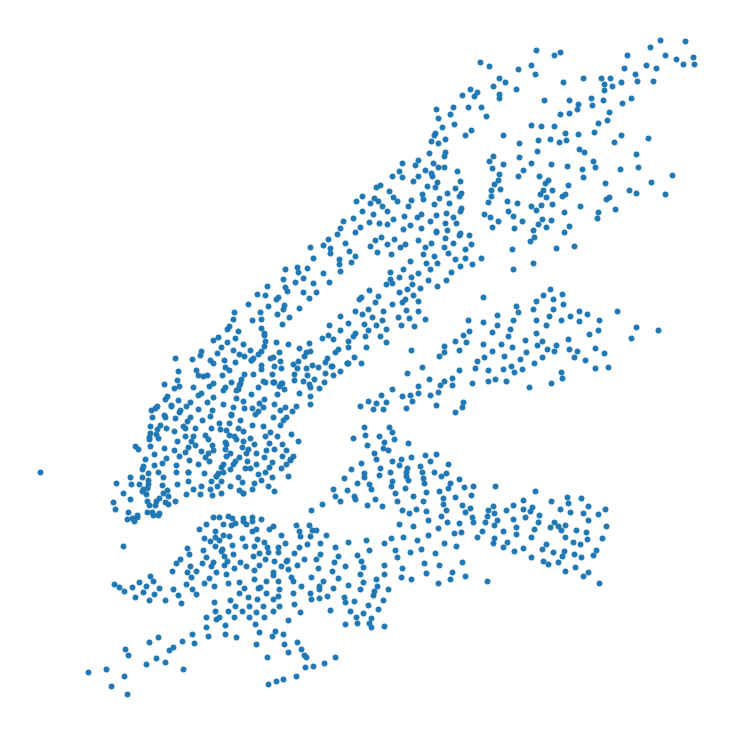

In [9]:
plt.figure(figsize = (10, 10))
nx.draw(stations, pos = stationPos,with_labels=False,arrows=False,node_size=25)

In [10]:
edgelist=[(gdf['start_station_name'][j],gdf['end_station_name'][j]) for j in gdf.index]

In [11]:
stations.add_edges_from(edgelist)

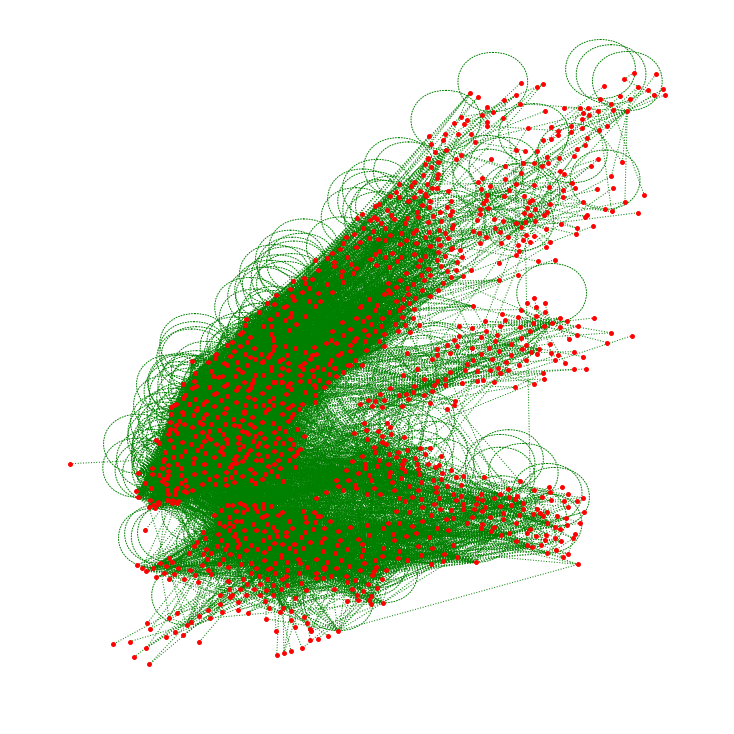

In [13]:
plt.figure(figsize = (10, 10))
nx.draw(stations,pos=stationPos,with_labels=False,node_size=15,style='dotted',edge_color='green',node_color = 'red')

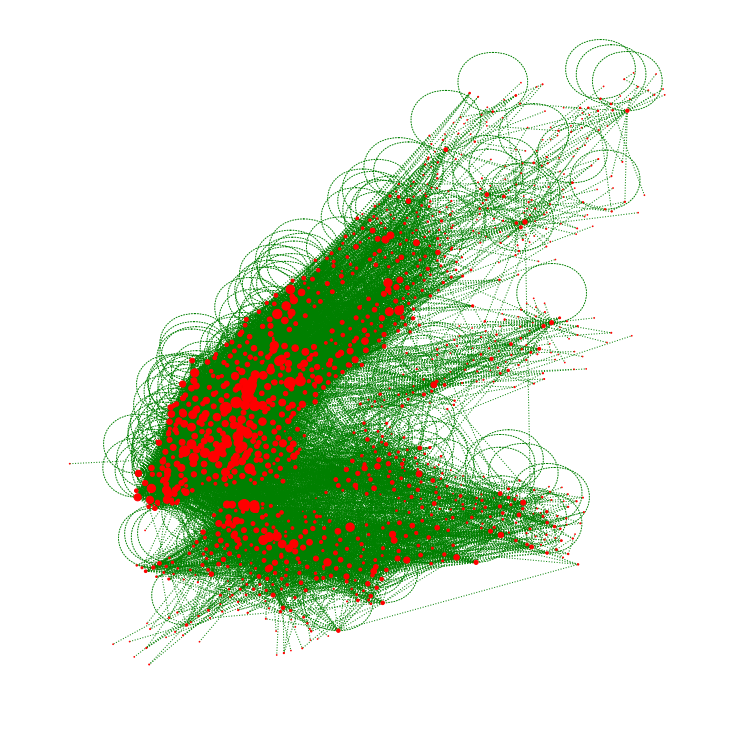

In [14]:
plt.figure(figsize = (10, 10))
nx.draw(stations,pos=stationPos,with_labels=False,node_size=0.5*np.array(list(dict(stations.degree()).values())),style='dotted',node_color = 'red', edge_color='green')

In [15]:
PCStations, PCStationsMod = pycombo.execute(stations, return_modularity=True, max_communities = 0) #keep number of communities flexible
PCStationsMod

0.42447088599338695

In [16]:
import matplotlib.pyplot as plt #plotting
def visualizePartition(G,partition,pos):
    N=len(G.nodes())
    plt.figure(figsize=(10, 10))
    PN=max(partition.values())
    my_cmap = matplotlib.cm.hsv(np.linspace(0,1,PN+1)) #create a colormap for a given number of communities
    c=[]
    for n in G.nodes():
        c.append(1.0*partition[n]/PN)
    nx.draw(G,pos=pos,with_labels=False,arrows=True,node_size=50,node_color=c,width=1,edge_color='black', style = 'dotted')

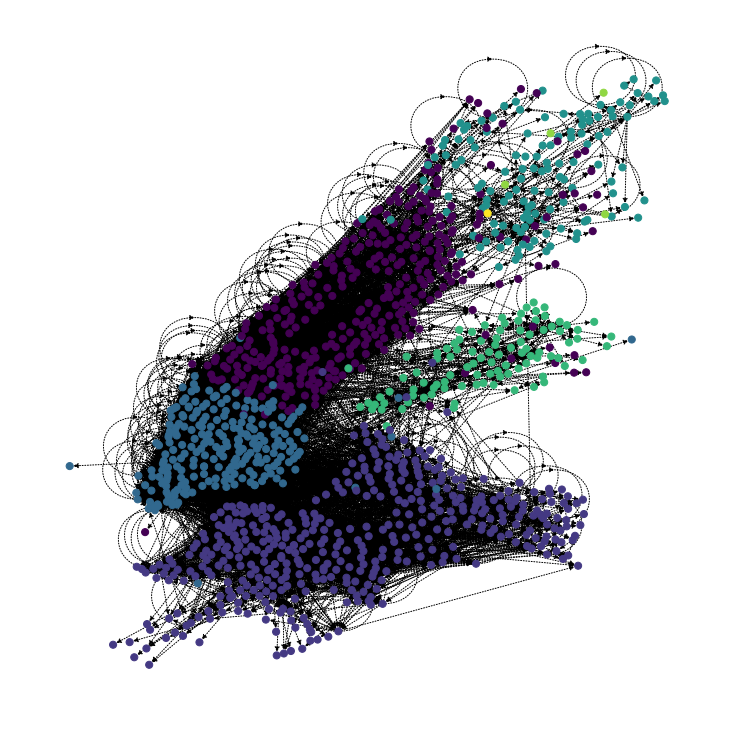

In [17]:
visualizePartition(stations,PCStations,stationPos)

In [ ]:
from heapq import nlargest
degree = nx.degree_centrality(stations)
res = nlargest(10, degree, key = degree.get)
for i in res:
    print(i, ': ',  degree[i])

6 Ave & W 33 St :  0.26365795724465557
Broadway & W 29 St :  0.20981789390340458
W 21 St & 6 Ave :  0.20506730007917656
6 Ave & W 34 St :  0.19873317498020585
Front St & Washington St :  0.1955661124307205
Pershing Square North :  0.19239904988123516
Cleveland Pl & Spring St :  0.18368962787015042
W 25 St & 6 Ave :  0.18131433095803642
Broadway & W 36 St :  0.18052256532066507
6 Ave & Broome St :  0.1749802058590657


In [ ]:
betweenneass = nx.betweenness_centrality(stations)
res = nlargest(10, betweenneass, key = betweenneass.get)
for i in res:
    print(i, ': ',  betweenneass[i])

Front St & Washington St :  0.05336457154261246
E Fordham Rd & Webster Ave :  0.04269553937668246
Melrose Ave & E 150 St :  0.04133142622727355
6 Ave & W 33 St :  0.03871566503804856
St. Nicholas Ave & W 126 St :  0.038377408284785135
Queens Plaza North & Crescent St :  0.030424378393942093
E 53 St & Madison Ave :  0.030069847802452553
St Nicholas Ave & Manhattan Ave :  0.026688974415980584
6 Ave & W 34 St :  0.02510202349813622
Broadway & W 36 St :  0.024795738418099296


In [ ]:
# Closeness Centrality
closeness = nx.closeness_centrality(stations)
res = nlargest(10, closeness, key = closeness.get)
for i in res:
    print(i, ': ',  closeness[i])

6 Ave & W 33 St :  0.4803488167502419
Front St & Washington St :  0.4589252241122842
W 21 St & 6 Ave :  0.4587561285986098
Broadway & W 36 St :  0.45774416655023054
6 Ave & W 34 St :  0.4569042689969274
Broadway & W 29 St :  0.45656917235666555
Pershing Square North :  0.4557335772388825
Cleveland Pl & Spring St :  0.45423718825852866
6 Ave & Broome St :  0.4517649248971796
W 25 St & 6 Ave :  0.4514373216158909


In [ ]:
# Pagerank Centrality
pagerank = nx.pagerank(stations, 0.85)
res = nlargest(10, pagerank, key = pagerank.get)
for i in res:
    print(i, ': ',  pagerank[i])

6 Ave & W 33 St :  0.00673017189329932
Front St & Washington St :  0.00625266064503492
Melrose Ave & E 150 St :  0.005499470446444735
6 Ave & W 34 St :  0.005138940272957919
W 21 St & 6 Ave :  0.005020414684270428
Broadway & W 29 St :  0.004998046022545925
St. Nicholas Ave & W 126 St :  0.004840096182242096
Broadway & W 36 St :  0.00476871809482856
Pershing Square North :  0.004761970369494199
E Fordham Rd & Webster Ave :  0.00460584775874014
